In [1]:
from food.tools import *
from food.paths import *
from food.psql import *
import requests
from food.qdrant import *
import torch
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=1, eps=1e-08)
import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

import shapely
import shapely.geometry
from PIL import ImageFont, ImageDraw, Image

dev


In [2]:
def read_image_from_url(url=None,path=None):
    if url: response = requests.get(url, stream=True)
    if path: pass
    return Image.open(response.raw)

In [3]:
def crop_image_to_square(img):
    height = img.size[1]//2*2
    left  = int((img.size[0]-height)/2)
    right =      img.size[0]-left
    return img.crop((left,0,right,height))

In [4]:
def box_area(box):
    return (box[2]-box[0])*(box[3]-box[1])

In [5]:
foods = read_sql('foods')
# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')

In [6]:
series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])

In [7]:
food_clips = series2tensor(foods['clip'])

/tmp/ipykernel_113046/2423156918.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/torch/csrc/utils/tensor_new.cpp:201.)
  series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])


In [8]:
def search_clip(url,head = 1):
    image_clip = requests.post(f'https://guru.skynet.center/image2vector/?url={url}').json()
    image_clip = torch.tensor(image_clip)
    df = foods.copy()
    df['score'] = cos(food_clips,image_clip)
    df = df.sort_values('score',ascending=False)[:head]

    return image_clip,df.reset_index()

In [9]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [15.00, 15.0]
plt.rcParams["figure.autolayout"] = True

In [10]:
url = 'https://image.shutterstock.com/z/stock-photo-top-view-of-a-restaurant-table-served-with-a-multi-course-set-lunch-and-drink-complex-lunch-1846351336.jpg'
image = get_image_from_url(url)
image = crop_image_to_square(image)
total_size = image.size[0]*image.size[1]

In [11]:
thershold = 0.0003
params = {'url':url,'thershold':thershold}
boxes,mask = requests.post('http://127.0.0.1:8185/get_boxes/?',params = params).json()
mask = np.array(mask)

In [12]:
df = pd.DataFrame()
df['area'] = [box_area(box) for box in boxes]
df['boxes'] = boxes
df = df.reset_index()

In [13]:
photo_id = url.split('/')[-1]
urls = []
for d in df[['index','boxes']].to_dict('records'):
    id,box = d.values()
    urls.append(f'https://glovo.away.guru/fragment_reference_images/{photo_id}_{id}.jpg')
clip_df = pd.DataFrame()
for u in urls:
    clip_df = clip_df.append(search_clip(u,head = 1)[1])
clip_df = clip_df.reset_index(drop = True)[['description','category','energy','protein','carb','fat','score']]

In [14]:
df = clip_df.join(df)
df = df[df['score']>0.24]
df = df.sort_values('area',ascending = False)
df = df.reset_index(drop=True).reset_index()
df = df.rename(columns = {'level_0':'box_area_rank'})
# df = df.sort_values('box_area_rank',ascending = False)
df['boxes'] = df['boxes'].apply(lambda b:[int(bb) for bb in b])

In [15]:
arrays= []
for row in df[['box_area_rank','energy','boxes']].iterrows():
    
    row = row[1]
    b = row['boxes']
    rank   = np.zeros(image.size)
    rank  [b[1]:b[3],b[0]:b[2]] = row['box_area_rank']
    
    energy = np.zeros(image.size)
    energy  [b[1]:b[3],b[0]:b[2]]= row['energy']
    
    row_array = np.stack([rank,energy])
    arrays.append(row_array)
arrays = np.stack(arrays)
arrays = arrays*mask.T

In [23]:
classes =  arrays[:,0,:,:].max(0)
df_count_classes = df[['box_area_rank','description']].set_index('box_area_rank').reindex(classes.reshape(classes.shape[0]*classes.shape[0]))
df_count_classes = df_count_classes.dropna().reset_index().groupby('description').count().sort_values('box_area_rank',ascending = False).head(20)
df_count_classes['%'] = (df_count_classes['box_area_rank']/df_count_classes['box_area_rank'].sum()).round(2)
r = df_count_classes[['%']].join(df.drop_duplicates('description').set_index('description')[['category','energy','protein','carb','fat']])
r

,%,category,energy,protein,carb,fat
description,,,,,,
"Bread, black",0.61,Yeast breads,250.0,8.70,47.50,3.10
"Bread, Italian, Grecian, Armenian",0.07,Yeast breads,259.0,9.49,48.11,2.73
"Pasta with cream sauce and poultry, restaurant",0.06,"Pasta mixed dishes, excludes macaroni and cheese",204.0,5.93,15.30,13.32
Topping from cheese pizza,0.05,Pizza,228.0,16.86,7.62,14.67
"Chicken or turkey salad, made with any type of fat free dressing",0.03,Poultry mixed dishes,110.0,13.37,6.21,3.81
Zwieback toast,0.02,"Crackers, excludes saltines",426.0,10.10,74.20,9.70
"Chicken breast, baked or broiled, skin not eaten, from fast food / restaurant",0.02,"Chicken, whole pieces",175.0,29.56,0.00,5.44
Alfredo sauce with poultry,0.02,"Dips, gravies, other sauces",153.0,7.10,1.20,13.59
"Chicken breast, baked, broiled, or roasted, skin eaten, from raw",0.02,"Chicken, whole pieces",192.0,26.25,0.00,8.80


In [24]:
colories_tensor = np.where((arrays[:,0,:,:] == arrays[:,0,:,:].max(0)),arrays[:,1,:,:],0).max(0)
colories_tensor[colories_tensor!=0].mean()

195.93533905462237

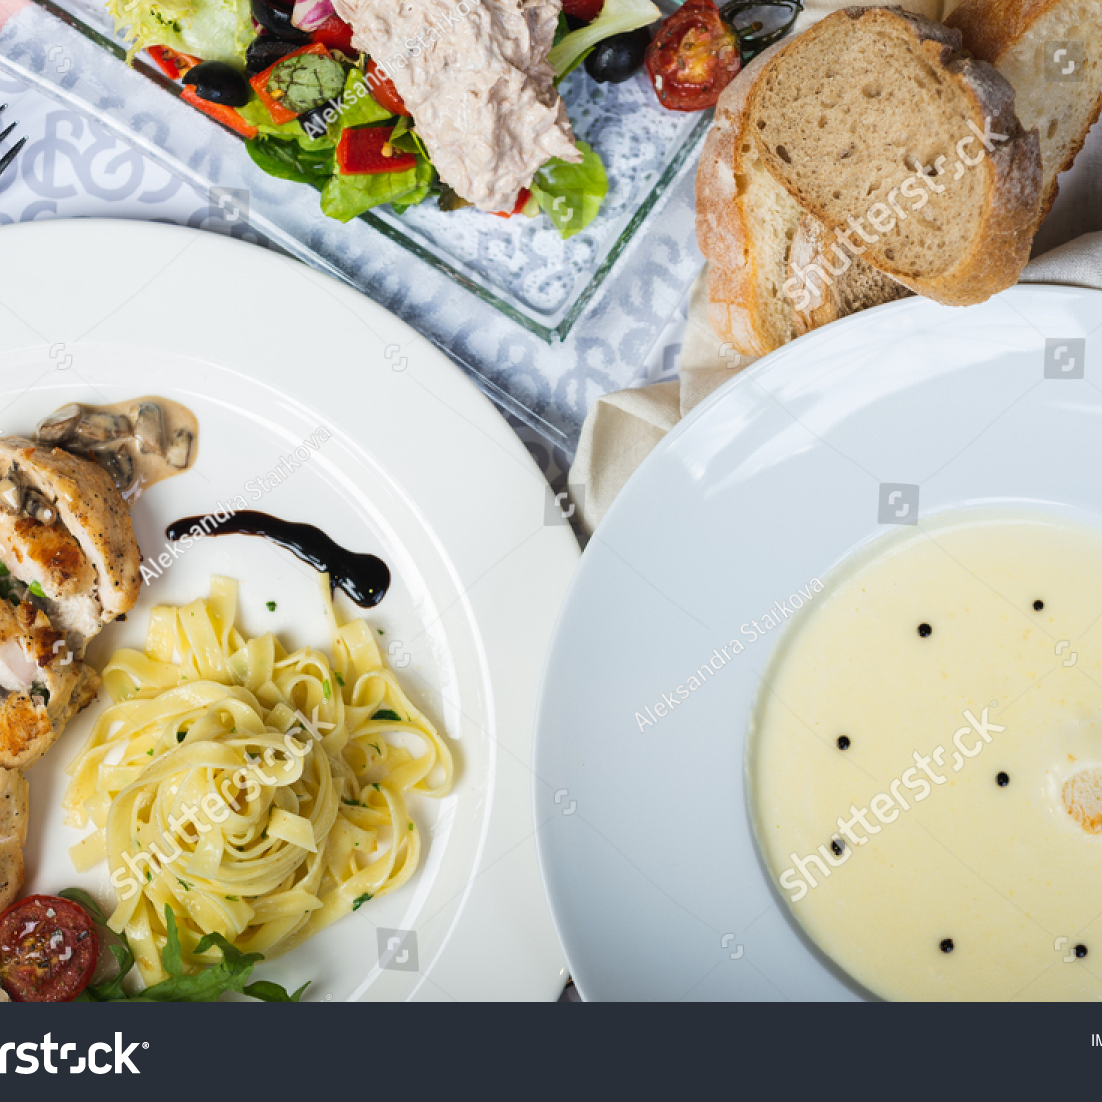

In [25]:
image

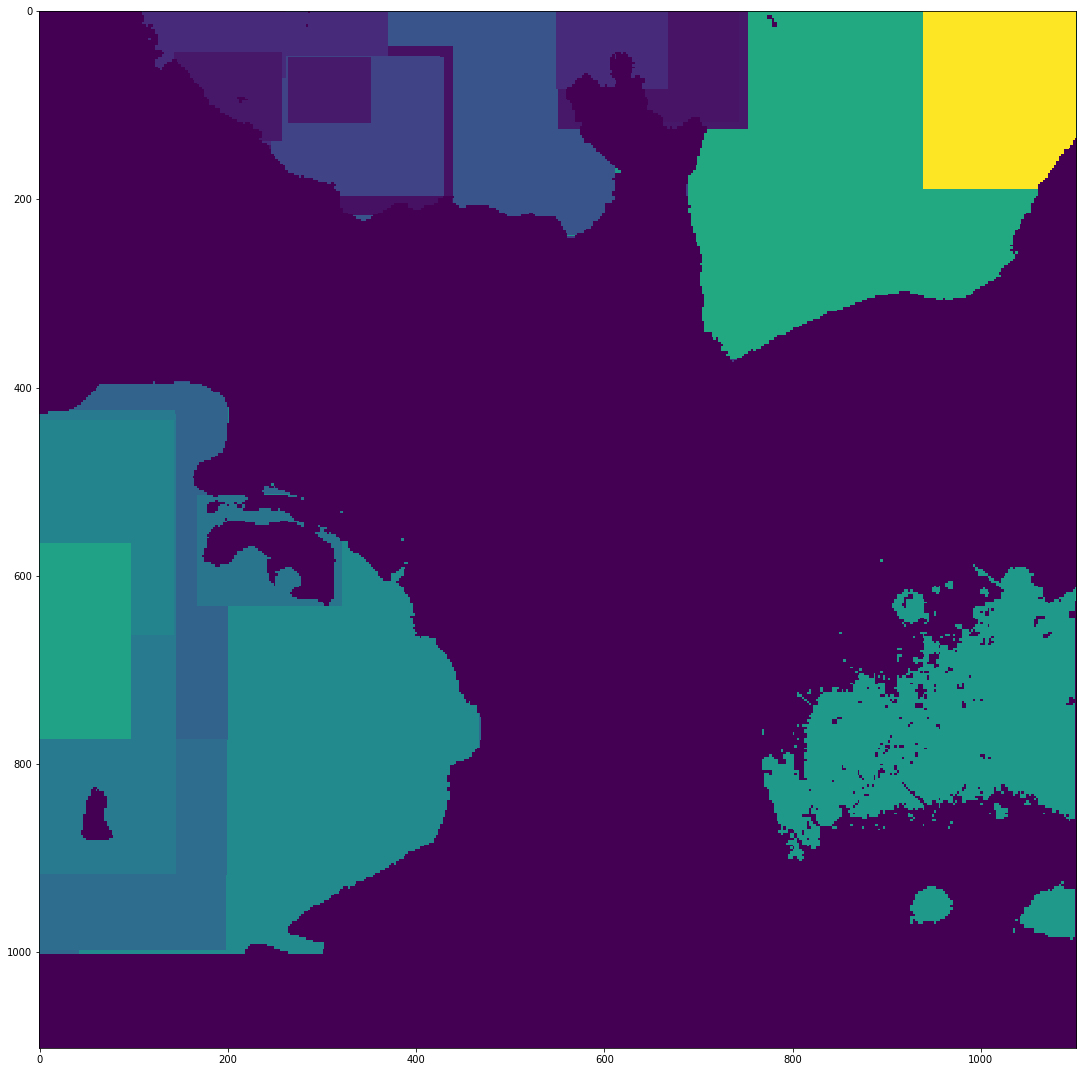

In [26]:
fig, ax = plt.subplots()
ax.imshow(image)
ax.imshow(colories_tensor, interpolation='none', alpha=1)